# Classification Based Machine Learning Algorithm

## Importing the MNIST dataset

His method of importing using sklearn did not work with firewall settings where I currently am. Found file online and imported it locally.

In [5]:
from scipy.io import loadmat
import os
mnist_path = os.getcwd() + '/Data/mldata/MNIST_original'
mnist_raw = loadmat(mnist_path)

In [6]:
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}
del(mnist_raw)

In [7]:
len(mnist['data'])
mnist['data'].shape

(70000, 784)

## Visualization

In [19]:
X, y = mnist['data'], mnist['target']

In [20]:
X.shape, y.shape

((70000, 784), (70000,))

In [21]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

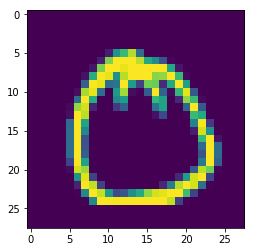

In [22]:
_ = X[1000]
_image = _.reshape(28,28)
plt.imshow(_image)

In [23]:
y[1000]

0.0

### Exercise: Locate the number 4 and plot the image

In [45]:
type(y)

numpy.ndarray

In [46]:
y == 4

array([False, False, False, ..., False, False, False])

In [49]:
np.where(y == 4)

(array([24754, 24755, 24756, ..., 65136, 65137, 65138], dtype=int32),)

In [50]:
y[24754]

4.0

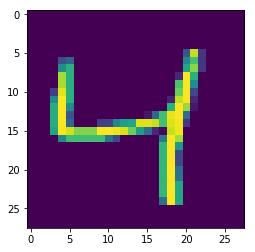

In [51]:
_ = X[24754]
_image = _.reshape(28,28)
plt.imshow(_image)

## Splitting the train and test sets

In [9]:
num_split = 60000

X_train, X_test, y_train, y_test = X[:num_split], X[num_split], y[:num_split], y[num_split:]

Tip: Typically we shuffle the training set. This ensures the training set is randomized and your data is consistent.

## Shuffling the dataset

Can also use scikit-learn's train-test-split

In [10]:
import numpy as np

In [11]:
shuffle_index = np.random.permutation(num_split)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

To simplify our problem, we will make this an exercise of "zero" or "non-zero", making it a two class problem

We need to first convert our target to 0 or non zero.

In [12]:
y_train_0 = (y_train == 0)

In [13]:
y_train_0

array([False, False, False, ..., False, False, False])

In [14]:
y_test_0 = (y_test == 0)

In [58]:
y_test_0

array([ True,  True,  True, ..., False, False, False])

At this point we can pick and classifier and train it. This is the iterative part of choosing and testing all the classifiers and tuning the hyperparameters.

***

## SGDClassifier

### Training

In [15]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(random_state=0)

In [25]:
clf.fit(X_train, y_train_0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

### Prediction

In [26]:
clf.predict(X[1000].reshape(1, -1))

array([ True])

We remember from above that X[1000] was a 0... Our model predicted it correctly.

***

## Performance Measures

## Measuring Accuracy Using Cross-Validation

### StratifiedKFold

Let's try with the StratifiedKFold stratified sampling to create multiple folds. At each iteration the classifier was cloned and trained using training folds and makes predictions on the test fold.

StratifiedKFold uses the Straified sampling concept:
 - The population is divided into homogeneous subgroups called strata
 - The right number of instances is sampled from each stratum
 - To guarantee that the test set is representative of the population

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
clf = SGDClassifier(random_state=0)

In [28]:
skfolds = StratifiedKFold(n_splits=3, random_state=100)

In [33]:
import warnings
warnings.filterwarnings('ignore')

for train_index, test_index in skfolds.split(X_train, y_train_0):
    clone_clf = clone(clf)
    X_train_fold = X_train[train_index]
    y_train_fold = (y_train_0[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_0[test_index])
    
    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print("{0:.4f}".format(n_correct / len(y_pred)))

0.9879
0.9842
0.9889


**cross_val_score using K-fold Cross-Validation**

K-fold cross-validation splits the training set into K-folds and then makes predictions and evaluates them one ach fold using a model trained on the remaining folds

In [34]:
from sklearn.model_selection import cross_val_score

In [37]:
cross_val_score(clf, X_train, y_train_0, cv=3, scoring='accuracy')

array([0.9879006 , 0.9842    , 0.98894945])

Notice, same numbers as the KFold loop... cv=3 uses the stratified KFold method with 3 strata.

### Exercise: Do same with 10 folds

In [38]:
cross_val_score(clf, X_train, y_train_0, cv=10, scoring='accuracy')

array([0.98766872, 0.988002  , 0.99133478, 0.98816667, 0.9865    ,
       0.987     , 0.984     , 0.98183031, 0.98699783, 0.98883147])

With 10, we have even more confidence that our model did well. All 10 accuracy scores are very high.

## Danger of Blindly Applying Evaluator As a Performance Measure

Let's check against a dumb classifier

In [41]:
1 - sum(y_train_0) / len(y_train_0) # Number of zeros / number of record

0.9012833333333333

A simple check shows that 90.1% of the images are not zero. Any time you guess the image is not zero, you will be right 90.1% of the time.

Bare this in mind when you are dealing with skewed datasets. Because of this, accuracy is generally not the preferred performance meansure for classifiers.

### Confusion Matrix

In [42]:
from sklearn.model_selection import cross_val_predict

In [43]:
y_train_pred = cross_val_predict(clf, X_train, y_train_0, cv=3)

In [44]:
from sklearn.metrics import confusion_matrix

In [45]:
confusion_matrix(y_train_0, y_train_pred)

array([[53820,   257],
       [  522,  5401]], dtype=int64)

Each row: Actual class

Each column: predicted class

First row: Non=zero images, the negative class:

 - 53820 were correctly classified as non-zero. **True negatives.**
 - Remaining 257 were wrongly classified as 0s. **False positive**

Second row: The images of zeros, the positive class:
 - 522 were invorrecly classified as 0s. **False negatives**
 - 5401 were correctly classified as 0s. **True positives**

### Precision

**Precision** measures the accuract of positive predictions. Also called the precision of the classifier
$$precision=\frac{True Positives}{True Positives - False Positives}$$

In [47]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_0, y_train_pred)

0.9545775892541534

### Recall

Precision is typically used with recall (Sensitivity or True Positive Rate). The ratio of positive instances that are correctly detected by the classifier.

$$recall=\frac{True Positives}{True Positives + False Negatives}$$

In [48]:
recall_score(y_train_0, y_train_pred)

0.9118689853114975

### F1 Score

$F_1$ score is the harmoic mean of the precision and recall. Regular mean gives equal weights to all values. Hardmonic mean gives more weights to low values

$$F_1=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}=2\times\frac{precision\times recal}{precision+recall}=\frac{TP}{TP+\frac{FN+FP}{2}}$$

The $F_1$ score favors classifiers that have similar precision and recall.

In [49]:
from sklearn.metrics import f1_score
f1_score(y_train_0, y_train_pred)

0.9327346515844918

~3% better than just randomly guessing.

## Precision / Recall Tradeoff

Increasing precision yields reduced recall and vice versa

In [50]:
clf = SGDClassifier(random_state=0)
clf.fit(X_train, y_train_0)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [51]:
y[1000]

0.0

In [53]:
y_scores = clf.decision_function(X[1000].reshape(1,-1))
y_scores

array([56303.39313394])

In [54]:
threshold = 0

In [55]:
y_some_digits_pred = (y_scores > threshold)

In [56]:
y_some_digits_pred

array([ True])

In [58]:
threshold = 60000
y_some_digits_pred = (y_scores > threshold)
y_some_digits_pred

array([False])

In [60]:
y_scores = cross_val_predict(clf, X_train, y_train_0, cv=3, method='decision_function')

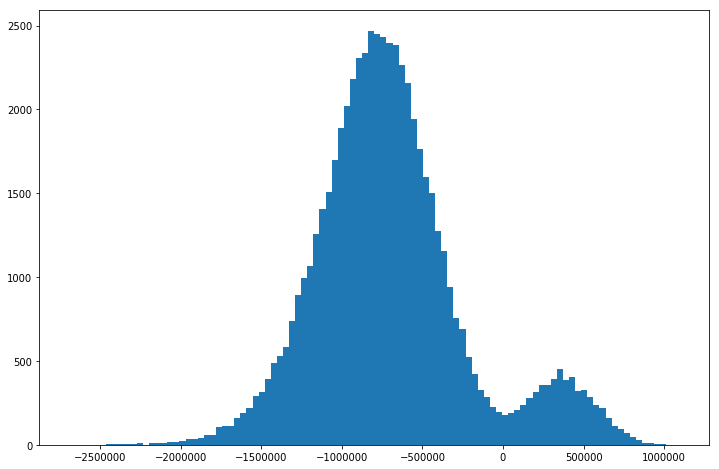

In [61]:
plt.figure(figsize=(12, 8));
plt.hist(y_scores, bins=100);

With the decision scores, we can compute precision and recall for all possible thresholds using the precision_recall_curve() function:

In [62]:
from sklearn.metrics import precision_recall_curve

In [63]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)

In [67]:
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0.0, 1.5])

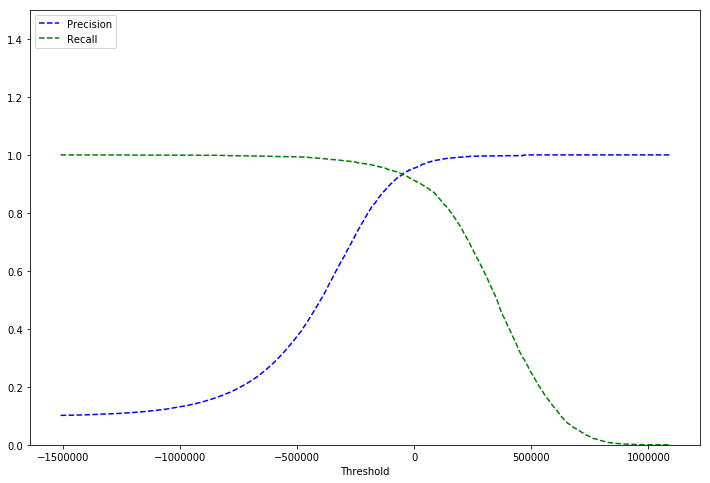

In [68]:
plt.figure(figsize=(12, 8));
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)
plt.show()

With this chart, you can select the threshold value that gives you the best precision/recall for your task.
<br>
<br>
<br>
<br>
One can also plot precisions against recalls to assist with the threshold selection

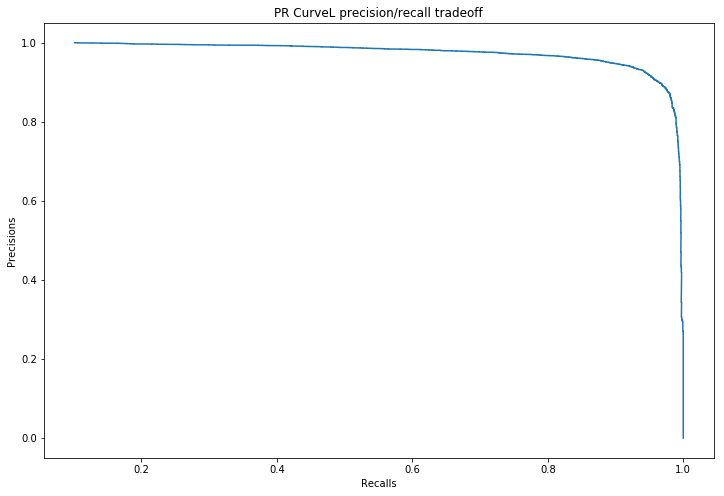

In [70]:
plt.figure(figsize=(12, 8));
plt.plot(precisions, recalls);
plt.xlabel("Recalls");
plt.ylabel("Precisions");
plt.title("PR CurveL precision/recall tradeoff");

### Setting High Precisions

Let's aim for 90% precision

In [71]:
len(precisions)

58385

In [72]:
len(thresholds)

58384

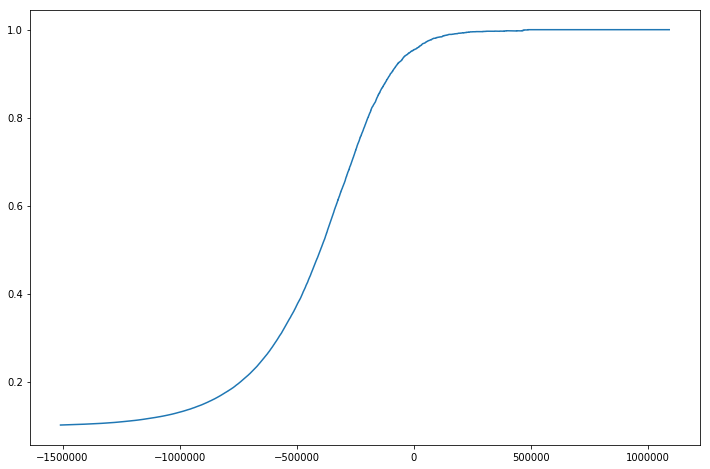

In [73]:
plt.figure(figsize=(12, 8));
plt.plot(thresholds, precisions[1:]);

In [79]:
idx = len(precisions[precisions < 0.9])

In [80]:
thresholds[idx]

-99503.29347717523

In [81]:
y_train_pred_90 = (y_scores > -99503)

In [82]:
precision_score(y_train_0, y_train_pred_90)

0.9001925545571245

In [83]:
recall_score(y_train_0, y_train_pred_90)

0.947155157859193

Now lets try 99%

In [88]:
idx = len(precisions[precisions < 0.99])

In [89]:
thresholds[idx]

168744.2661514574

In [91]:
y_train_pred_99 = (y_scores > thresholds[idx])

In [92]:
precision_score(y_train_0, y_train_pred_99)

0.9900233496073021

In [93]:
recall_score(y_train_0, y_train_pred_99)

0.7874387979064663

## The Receiver Operating Characteristics (ROC) Curve

Instead of plotting precision vs recall values, the ROC curve plots the true positive rate (recall) against the false positive rate. The false positive rate (FPR) is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true positive rate, which is the ratio of negative instances that are correctly classified as negative.

The TNR is also called specificity. Hence the ROC curve plots sensitivity vs 1 - specificity.

In [94]:
from sklearn.metrics import roc_curve

In [95]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)

In [100]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")

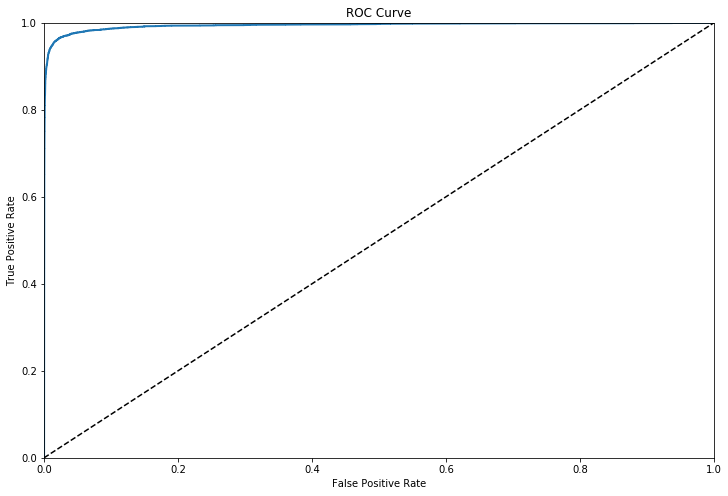

In [101]:
plt.figure(figsize=(12, 8));
plot_roc_curve(fpr, tpr)
plt.show();

In [102]:
from sklearn.metrics import roc_auc_score

In [103]:
roc_auc_score(y_train_0, y_scores)

0.9940872794079362

Use PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives.

Use ROC curve whenever the negative class is rare or when you care more about the false negatives than the false positives.

In the example above, the ROC curve seems to suggest that the classifier is good. However, when you look at the PR curve, you can see there is room for improvement.

## Model Comparison

### Random Forest

In [104]:
from sklearn.ensemble import RandomForestClassifier

In [105]:
f_clf = RandomForestClassifier(random_state=0)

In [106]:
y_probas_forest = cross_val_predict(f_clf, X_train, y_train_0,
                                   cv=3, method='predict_proba')

In [107]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_0, y_scores_forest)

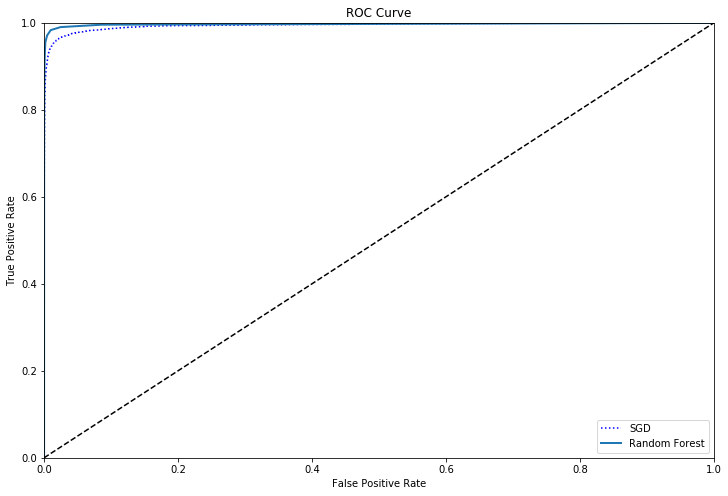

In [108]:
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show();

In [109]:
roc_auc_score(y_train_0, y_scores_forest)

0.9970998248690671

In [110]:
f_clf.fit(X_train, y_train_0)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [112]:
y_train_rf = cross_val_predict(f_clf, X_train, y_train_0, cv=3)

In [113]:
precision_score(y_train_0, y_train_rf)

0.9888789237668162

In [114]:
recall_score(y_train_0, y_train_rf)

0.930778321796387

We can see that the RF model outperforms the SGD model in regards to both the ROC and PR curves.

In [138]:
confusion_matrix(y_train_0, y_train_rf)

array([[54015,    62],
       [  410,  5513]], dtype=int64)